In [1]:
!pip3 install hdbscan 
!pip3 install bertopic

In [2]:
import spacy
import pandas as pd

import json
import spacy
import requests
import random
import time

import spacy
from tqdm import tqdm 
from collections import Counter

import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

import pyLDAvis
import pyLDAvis.gensim

import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer

In [3]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer

/Users/lydiafield/anaconda3/lib/python3.11/site-packages/plotly/express/imshow_utils.py:24: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),
/Users/lydiafield/anaconda3/lib/python3.11/site-packages/plotly/graph_objs/__init__.py:288: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
/Users/lydiafield/anaconda3/lib/python3.11/site-packages/plotly/graph_objs/__init__.py:288: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
/Users/lydiafield/anaconda3/lib/python3.11/site-packages/plotly/graph_objs/__init__.py:288: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
/Users/lydiafield/anaconda3/

In [4]:
!pip3 install -U pip setuptools wheel
!pip3 install -U spacy
!pip3 install -U scattertext

In [5]:
import scattertext as st

In [518]:
blue = pd.read_csv('/Users/lydiafield/Desktop/Semestre 1/Digital Methods/blue_states.csv')
red = pd.read_csv('/Users/lydiafield/Desktop/Semestre 1/Digital Methods/red_states.csv')

In [519]:
blue['State'] = 'blue'
red['State'] = 'red'

In [520]:
blue_s = pd.DataFrame()
red_s = pd.DataFrame()

In [521]:
blue_s = blue[['Hit Sentence','State']].copy()
red_s = red[['Hit Sentence','State']].copy()

In [522]:
red_blue = pd.concat([blue_s,red_s], ignore_index=True)
red_blue = red_blue.rename(columns={'Hit Sentence':'Tweets'})

In [523]:
from nltk.corpus import stopwords
import nltk 
nltk.download('stopwords')
stop = stopwords.words('english')

from sklearn.feature_extraction import text
stops = text.ENGLISH_STOP_WORDS

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lydiafield/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [524]:
#red_blue['Tweets']=red_blue['Tweets'].apply(lambda x: [item for item in str(x).split() if item not in stop])
red_blue['Tweets_nsw'] = red_blue["Tweets"].apply(lambda words: ' '.join(word.lower() for word in str(words).split() if word not in stops))
#red_blue['Tweets'] = red_blue['Tweets'].apply(lambda x: ' '.join([word for word in str(x).split() if word in (stop)]))

In [525]:
red_blue

,Tweets,State,Tweets_nsw
0,California passes “anti-book ban” legislation....,blue,california passes “anti-book ban” legislation....
1,@GovPritzker: End book bans. Period. ; Govern...,blue,@govpritzker: end book bans. period. ; governo...
2,Gunman kills 8 in rampage at North Texas outle...,blue,gunman kills 8 rampage north texas outlet mall...
3,"@GavinNewsom: Dear Mr. Newsom, please read th...",blue,"@gavinnewsom: dear mr. newsom, read book: /90j..."
4,In response to Illinois passing a law against ...,blue,"in response illinois passing law “book bans”, ..."
...,...,...,...
11265,But it’s important to look beyond this. The pe...,red,but it’s important look this. the people like ...
11266,Boycott Florida! Say gay! Stop forced birth! R...,red,boycott florida! say gay! stop forced birth! r...
11267,"Amanda Gorman, youngest Inaugural Poet, answer...",red,"amanda gorman, youngest inaugural poet, answer..."
11268,Tonight @MeyerDems voted for a resolution by L...,red,tonight @meyerdems voted resolution lisa stant...


In [526]:
red_blue = red_blue.drop('Tweets', axis=1)
red_blue = red_blue.rename(columns={'Tweets_nsw':'Tweets'})

In [555]:
red_blue['Tweets'] = red_blue.Tweets.str.replace(r'\b(\w{1,3})\b', '')
red_blue['Tweets'] = red_blue.Tweets.str.replace('nan', '')
#docs2 = [[token.lemma_.lower() for token in doc if  token.is_alpha] for doc in documents_nlp]

In [556]:
red_blue

,State,Tweets
0,blue,california passes “anti-book ban” legislation....
1,blue,@govpritzker: end book bans. period. ; governo...
2,blue,gunman kills 8 rampage north texas outlet mall...
3,blue,"@gavinnewsom: dear mr. newsom, read book: /90j..."
4,blue,"in response illinois passing law “book bans”, ..."
...,...,...
11265,red,but it’s important look this. the people like ...
11266,red,boycott florida! say gay! stop forced birth! r...
11267,red,"amanda gorman, youngest inaugural poet, answer..."
11268,red,tonight @meyerdems voted resolution lisa stant...


In [557]:
nlp = spacy.load("en_core_web_sm")

In [558]:
corpus = st.CorpusFromPandas(red_blue,category_col='State',text_col='Tweets',nlp=nlp).build()
corpus

In [559]:
term_freq_df = corpus.get_term_freq_df()

In [560]:
term_freq_df['Blue Score'] = corpus.get_scaled_f_scores('blue')

In [561]:
term_freq_df['Red Score'] = corpus.get_scaled_f_scores('red')

In [562]:
html = st.produce_scattertext_explorer(corpus,category='blue',category_name='Blue States',not_category_name='Red States',width_in_pixels=1000)

In [563]:
open("red_blue_scatter.html", 'wb').write(html.encode('utf-8'))

4427339

In [564]:
term_freq_df[:10000]

,blue freq,red freq,Blue Score,Red Score
term,,,,
california,182,33,0.986441,0.013559
passes,20,12,0.842194,0.157806
anti,178,283,0.846221,0.153779
-,366,525,0.858718,0.141282
book,2363,3737,0.846878,0.153122
...,...,...,...,...
the washington,4,4,0.564628,0.435372
post /vx3mptnn8,2,0,0.558590,0.441410
/vx3mptnn8 g,2,0,0.558590,0.441410


In [565]:
tf = term_freq_df
tf = tf.reset_index()

In [566]:
blue_scores = tf.sort_values(by='Blue Score', ascending=False)
red_scores = tf.sort_values(by='Red Score', ascending=False)
blue_scores.drop(blue_scores[blue_scores['term']=='nan'].index, inplace=True)
red_scores.drop(red_scores[red_scores['term']=='nan'].index, inplace=True)
blue_scores = blue_scores.set_index('term')
red_scores = red_scores.set_index('term')
#df.drop(df[df['Fee'] >= 24000].index, inplace = True)
#tf['Blue Score'].head(10)

In [567]:
blue_scores = blue_scores.head(11) 

In [568]:
blue_scores['Score'] = blue_scores['Blue Score']

In [569]:
dfb = blue_scores['Score']

In [570]:
blue_scores['blue_scale']=(dfb-dfb.min())/(dfb.max()-dfb.min())

In [571]:
blue_scores['Score'] = blue_scores['blue_scale']

In [572]:
red_scores = red_scores.head(11) 

In [573]:
dfr = red_scores['Red Score']

In [574]:
red_scores['red_scale']=(dfr-dfr.min())/(dfr.max()-dfr.min())

In [575]:
red_scores['red_scale'] = red_scores['red_scale']*(-1)

In [576]:
red_scores['Score'] = red_scores['red_scale']

In [577]:
red_blue_scores = pd.concat([blue_scores, red_scores])

In [578]:
red_blue_scores = red_blue_scores.reset_index()

In [579]:
red_blue_scores = red_blue_scores.sort_values(by='Score', ascending=False)

In [580]:
red_blue_scores.drop(red_blue_scores[red_blue_scores['Score']==0.0].index, inplace=True)
#blue_scores.drop(blue_scores[blue_scores['term']=='nan'].index, inplace=True)

In [581]:
red_blue_scores

,term,blue freq,red freq,Blue Score,Red Score,Score,blue_scale,red_scale
0,illinois state,67,3,1.000000,0.000000,1.000000,1.000000,NaN
1,@govpritzker,42,1,0.996126,0.003874,0.669351,0.669351,NaN
2,illinois,407,35,0.996108,0.003892,0.667823,0.667823,NaN
3,- 2022,43,2,0.994973,0.005027,0.570886,0.570886,NaN
4,. pritzker,54,6,0.993033,0.006967,0.405336,0.405336,NaN
5,@giannoulias,43,3,0.992799,0.007201,0.385288,0.385288,NaN
6,pritzker,116,14,0.992676,0.007324,0.374805,0.374805,NaN
7,2022 school,43,4,0.990567,0.009433,0.194841,0.194841,NaN
8,just 11,41,3,0.990529,0.009471,0.191584,0.191584,NaN
9,2021 -,47,6,0.989606,0.010394,0.112786,0.112786,NaN


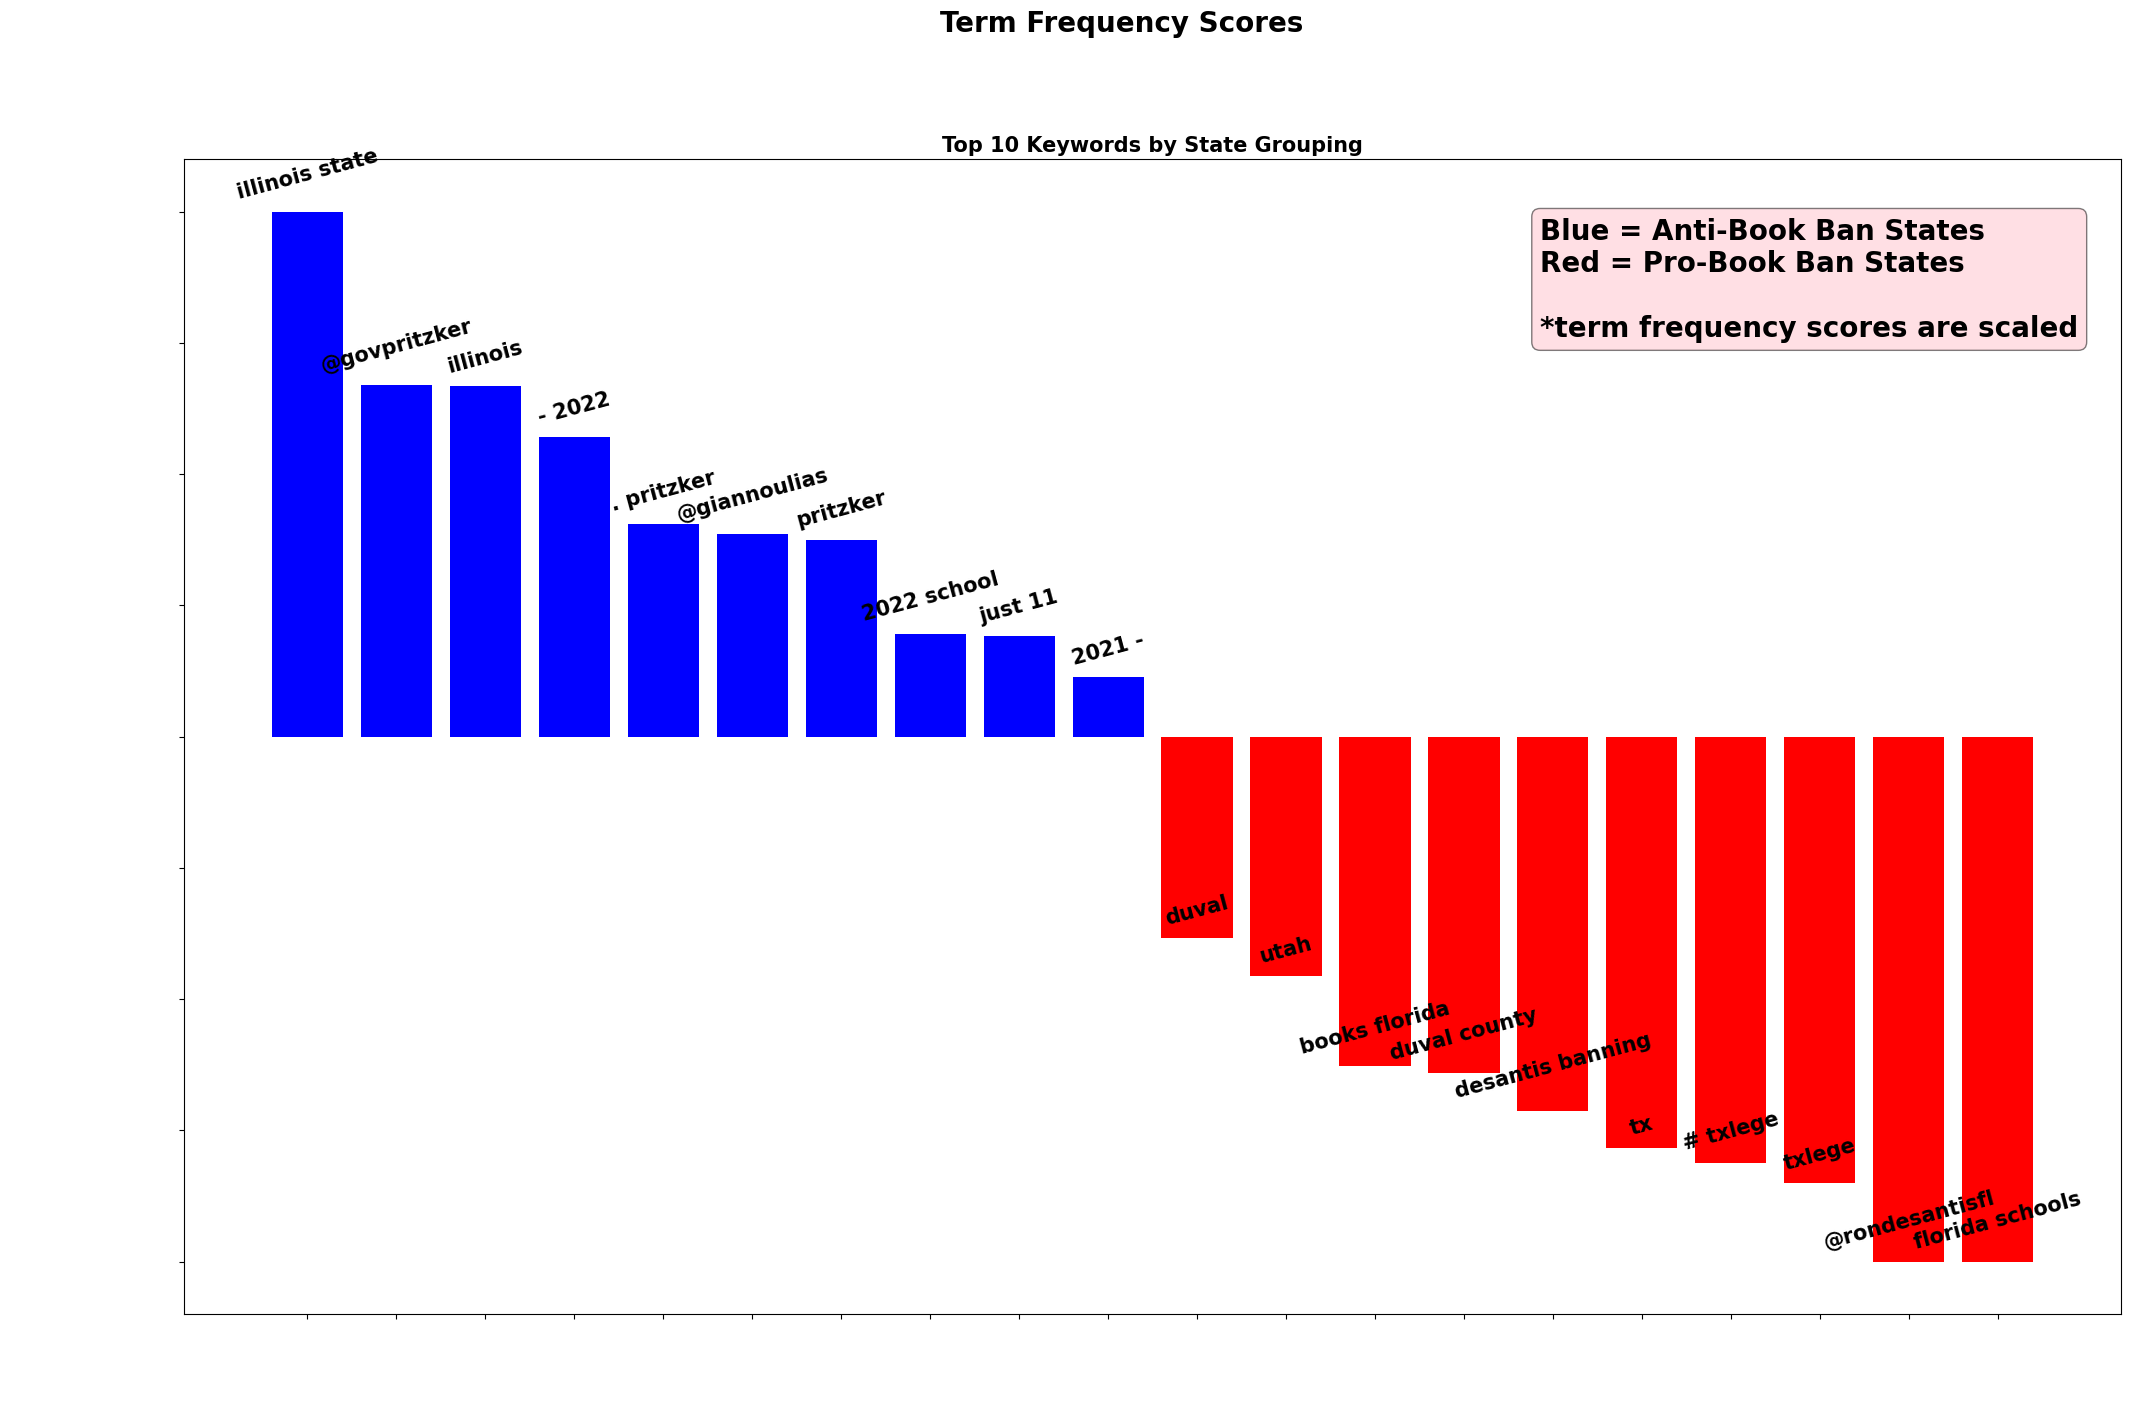

In [582]:
fig = plt.figure(figsize=(25,15))
ax = fig.add_subplot(1,1,1)
ax.set_xticklabels(red_blue_scores['term'], rotation=45, size=10, color='white')
ax.set_yticklabels(red_blue_scores['Score'], color='white')
p_color = [('blue' if i > 0 else 'red') for i in red_blue_scores['Score']]

props = dict(boxstyle='round', facecolor='pink', alpha=0.5)

plt.bar(red_blue_scores['term'], red_blue_scores['Score'], color=p_color)

plt.suptitle("Term Frequency Scores", fontsize=20, weight='bold')
plt.title("Top 10 Keywords by State Grouping", fontsize=15, weight='bold')
plt.ylabel(None)
plt.xlabel(None)

for x,y in zip(red_blue_scores['term'],red_blue_scores['Score']):

    label = x

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', rotation=15, weight='bold', fontsize=15)

plt.text(0.70, 0.95, "Blue = Anti-Book Ban States \nRed = Pro-Book Ban States\n\n*term frequency scores are scaled", transform=ax.transAxes, fontsize=20, weight='bold',
        verticalalignment='top', bbox=props)


plt.savefig("top_terms_red_blue")

Common Word Comparisons - Blue States

In [583]:
bwords = list(blue['Hit Sentence'])
bwords = [str(e) for e in bwords]
bwords_nlp = []
for d in tqdm(nlp.pipe(bwords,n_process=5),total=len(bwords)):
    bwords_nlp.append(d)

100%|██████████████████████████████████████| 4942/4942 [00:17<00:00, 290.11it/s]


In [584]:
bwords_filter = [[token.lemma_.lower() for token in doc if  token.is_alpha] for doc in bwords_nlp]
bwords_filter = [[token.text for token in doc if not token.is_stop] for doc in bwords_nlp]
bwords_filter = [[token for token in doc if len(token) > 1] for doc in bwords_filter]
bwordlist = sum(bwords_filter, [])

In [585]:
from collections import Counter

In [586]:
def remove_words(br_list):
    for word in bwordlist:
        if word in br_list:
            bwordlist.remove(word)

In [587]:
br_list = ['ban','banning','banned','book','QT','bans','books','Book','banned','...', '  ','nan','like','nan']

In [592]:
remove_words(br_list)

In [593]:
bcommon_words = Counter(bwordlist).most_common(20)

In [590]:
def Convert(tup, di):
    for a, b in tup:
        di.setdefault(a, []).append(b)
    return di

In [594]:
bcommon_dict = {}
Convert(bcommon_words,bcommon_dict)

{'school': [805],
 'people': [571],
 'kids': [498],
 'schools': [477],
 'want': [473],
 'libraries': [456],
 'books': [434],
 'state': [407],
 'Illinois': [402],
 'history': [398],
 'Republicans': [393],
 'children': [372],
 'read': [356],
 'Florida': [336],
 'public': [330],
 'right': [291],
 'America': [245],
 'library': [240],
 'year': [237],
 '@GavinNewsom': [236]}

In [595]:
bcommon = pd.DataFrame.from_dict(bcommon_dict, orient='index').reset_index()

In [596]:
bcommon = bcommon.rename(columns={'index':'word', 0: 'count'})

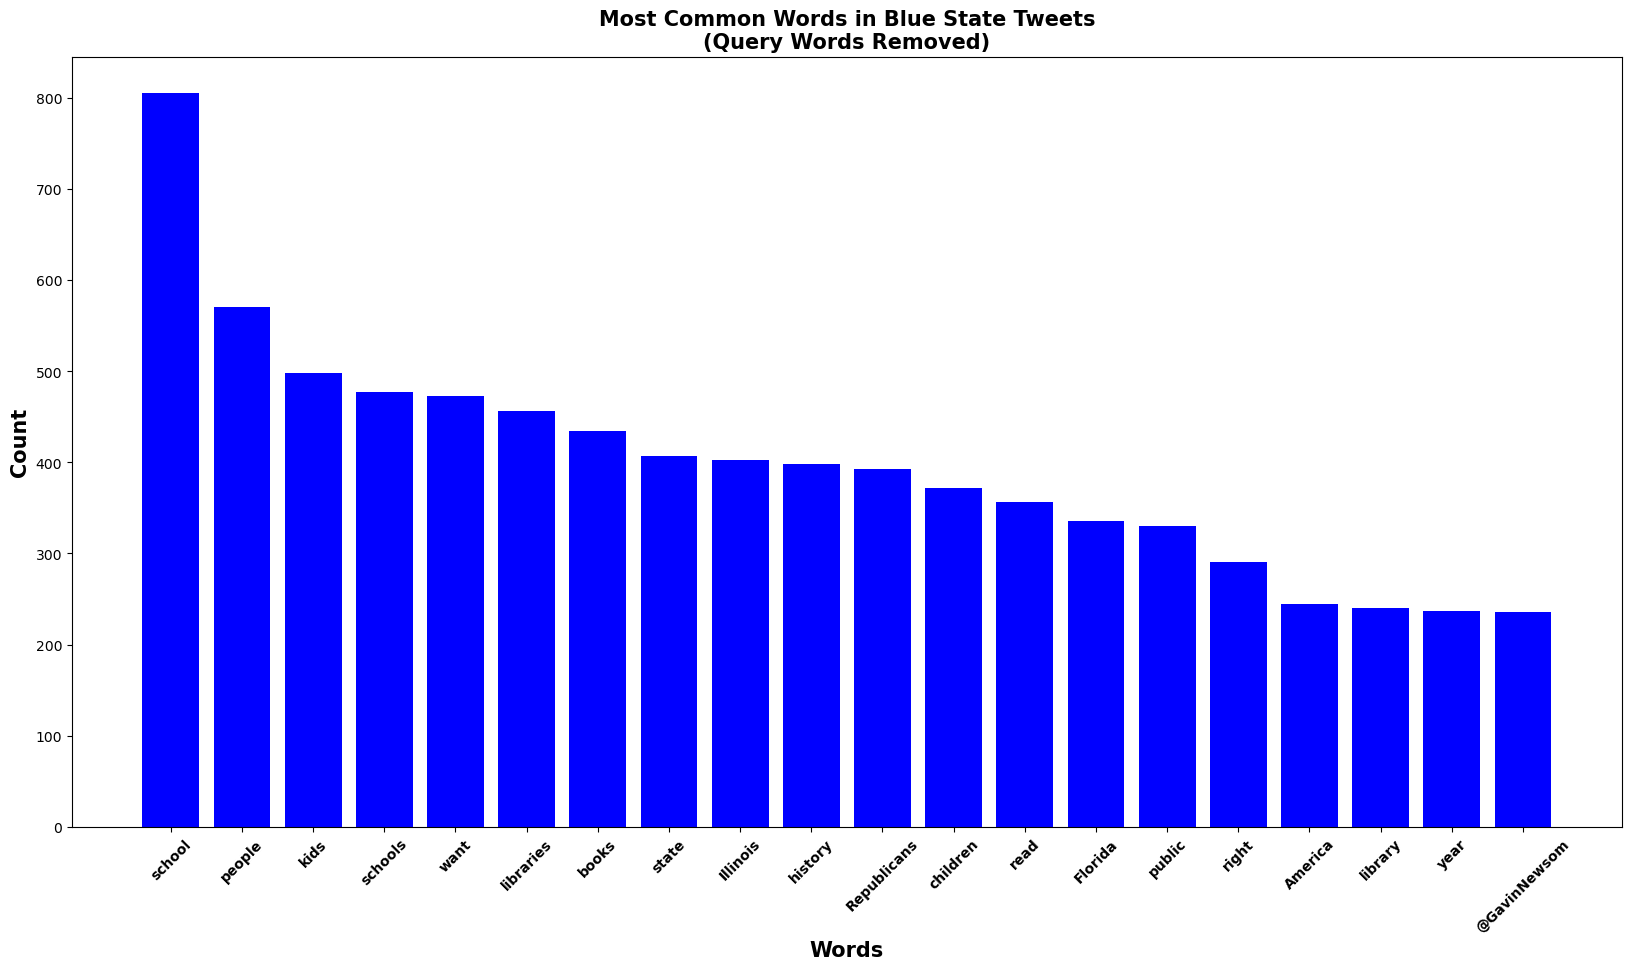

In [597]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
ax.set_xticklabels(bcommon['word'], rotation=45,fontsize=10,weight='bold')
ax.set_title('Most Common Words in Blue State Tweets\n(Query Words Removed)',fontsize=15,weight='bold')

ax.set_xlabel("Words",fontsize=15,weight='bold')
ax.set_ylabel("Count",fontsize=15,weight='bold')

plt.bar(bcommon['word'],bcommon['count'],color='blue')
plt.savefig("blue_top_20.png")

Common Word Comparisons - Red States

In [598]:
rwords = list(red['Hit Sentence'])
rwords = [str(e) for e in rwords]
rwords_nlp = []
for d in tqdm(nlp.pipe(rwords,n_process=5),total=len(rwords)):
    rwords_nlp.append(d)

100%|██████████████████████████████████████| 6328/6328 [00:22<00:00, 277.71it/s]


In [599]:
rwords_filter = [[token.lemma_.lower() for token in doc if  token.is_alpha] for doc in rwords_nlp]
rwords_filter = [[token.text for token in doc if not token.is_stop] for doc in rwords_nlp]
rwords_filter = [[token for token in doc if len(token) > 1] for doc in rwords_filter]
rwordlist = sum(rwords_filter, [])

In [600]:
def remove_wordsr(rr_list):
    for word in rwordlist:
        if word in rr_list:
            rwordlist.remove(word)

In [611]:
rr_list = ['ban','banning','banned','book','QT','bans','books','Book','banned','...', '  ','nan','like','nan','books','books']

In [612]:
remove_wordsr(rr_list)

In [613]:
rcommon_words = Counter(rwordlist).most_common(20)

In [604]:
def Convert(tup, di):
    for a, b in tup:
        di.setdefault(a, []).append(b)
    return di

In [614]:
rcommon_dict = {}
Convert(rcommon_words,rcommon_dict)

{'Florida': [2564],
 'DeSantis': [1840],
 'school': [1371],
 'schools': [949],
 'Ron': [833],
 'people': [727],
 'state': [645],
 'history': [613],
 'libraries': [582],
 'public': [577],
 'children': [564],
 'kids': [541],
 'Texas': [540],
 'want': [519],
 'library': [452],
 'right': [446],
 'Republicans': [443],
 'read': [438],
 'County': [378],
 'education': [359]}

In [615]:
rcommon = pd.DataFrame.from_dict(rcommon_dict, orient='index').reset_index()

In [616]:
rcommon = rcommon.rename(columns={'index':'word', 0: 'count'})

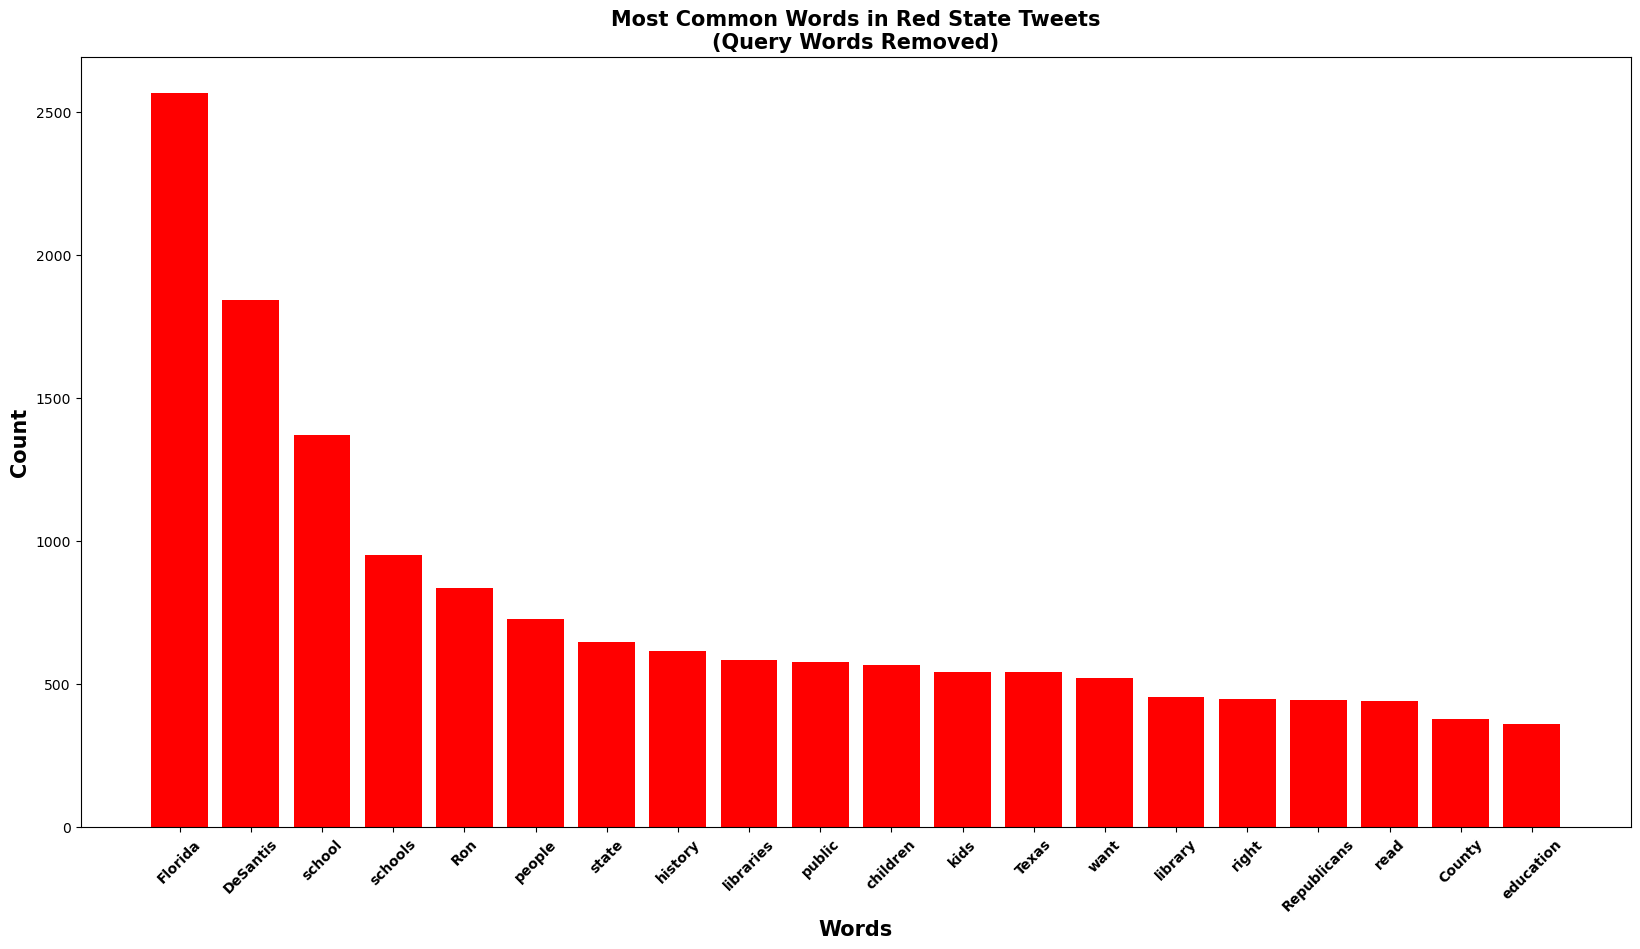

In [617]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
ax.set_xticklabels(rcommon['word'], rotation=45,fontsize=10,weight='bold')
ax.set_title('Most Common Words in Red State Tweets\n(Query Words Removed)',fontsize=15,weight='bold')

ax.set_xlabel("Words",fontsize=15,weight='bold')
ax.set_ylabel("Count",fontsize=15,weight='bold')

plt.bar(rcommon['word'],rcommon['count'],color='red')
plt.savefig("red_top_20.png")